# Predictive II Voice Identification Project

<a name="top"></a>
- ### Data Preperation
    + [Standardize](#STD)
    + [PCA](#PCA)
<br>
<br>
- ### Models
    + [Logistic Regression](#LR)
    + [Neural Network](#NNET)
    + [CART](#CART)
    + [KNN](#KNN)
    + [SVM](#SVM)
    + [Boosted Tree](#BT)
    + [Random Forest](#RF)
    + [XGBoost](#XGB)
    + [GAM](#GAM)
    + [Naive Bayes](#NB)
<br>
<br>
- ### Evaluation
    + [Results](#RESULTS)

In [13]:
import os
path=os.getcwd()
os.chdir(path)

In [186]:
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn import neighbors
from sklearn.svm import SVC
from pygam import LogisticGAM
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score



import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance

import pickle

%matplotlib inline
%load_ext watermark
%watermark -a 'VoiceGroup' -d -t -v -p numpy,pandas,xgboost,sklearn,matplotlib,pygam

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
VoiceGroup 2018-03-09 22:19:21 

CPython 3.6.3
IPython 6.1.0

numpy 1.13.3
pandas 0.20.3
xgboost 0.4
sklearn 0.19.1
matplotlib 2.1.0
pygam 0.4.0



## Data Preparation

<a name="STD"></a>
### Standardize

[Return to top](#top)

In [15]:
def standardize(column):
    return (column - np.mean(column))/np.std(column)

voice = pd.read_csv("voice.csv")
y = voice.label
voice = voice.drop(labels = "label", axis = 1)
voice = voice.apply(standardize)

<a name="PCA"></a>
### PCA

[Return to top](#top)

In [16]:
pca = PCA(n_components=20,random_state=1)
pca.fit(voice) 

PCA(copy=True, iterated_power='auto', n_components=20, random_state=1,
  svd_solver='auto', tol=0.0, whiten=False)

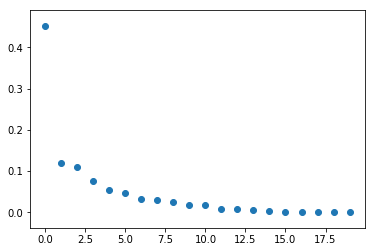

In [17]:
l = pca.explained_variance_ratio_
plt.scatter(y=l,x=range(20))
plt.show()

In [18]:
#Choosing the first six principle components based on the plot above
print("the first six principle components could explain %s variation" % sum(l[:6]))
pca = PCA(n_components=6,random_state=1)
pca.fit(voice)
voice_pc = pd.DataFrame(pca.transform(voice),columns=["PC1","PC2","PC3","PC4","PC5","PC6"])

the first six principle components could explain 0.855256063608 variation



## Models

<a name="LR"></a>
### Logistic Regression
[Return to top](#top)

##### Without PC

In [31]:
lr = LogisticRegression()
lr.fit(voice,y)
kfold = KFold(n_splits=10,random_state=1)
lr_score_pc=np.mean(cross_val_score(lr,X=voice,y=y,cv=kfold))
lr_score_pc

0.95864413209280053

##### With PC

In [32]:
lr = LogisticRegression()
lr.fit(voice_pc,y)
kfold = KFold(n_splits=10,random_state=1)
lr_score_npc=np.mean(cross_val_score(lr,X=voice_pc,y=y,cv=kfold))
lr_score_npc

0.84406620612546424

<a name="NNET"></a>
## Neural Network

[Return to top](#top)

#### Without PC

In [ ]:
# gird search
alphaList = [0.0001,0.001,0.01,0.1,1,10]
numNodesList = [20,30,40,50,60,70,80,90,100]
solverList = ["lbfgs","adam"]
ccr = pd.DataFrame(({"alpha":[],"numNodes":[],"solver":[]"score":[]}))

kfold = KFold(n_splits=10,random_state=1)
for alpha in alphaList:
    for numNodes in numNodesList:
        for solver in solverList:
            nn = MLPClassifier(hidden_layer_sizes=numNodes, activation="logistic", alpha=alpha, solver=solver, random_state=1)
            nn.fit(X=voice,y=y)
            scores = cross_val_score(nn, X=voice, y=y, cv=kfold)
            ccr = ccr.append(pd.Series((alpha, numNodes, solver, scores.mean()), index=["alpha", "numNodes","solver","score"]), ignore_index=True)
        print(str(alpha)+" "+str(numNodes)+" finished")

ccr
print(ccr[ccr.score==ccr.score.max()])

Best model param: alpha = 0.0001, hidden_layer_sizes=70, solver="adam"

In [33]:
# best model
kfold = KFold(n_splits=10,random_state=1)
nn = MLPClassifier(hidden_layer_sizes=70,activation="logistic",alpha=0.0001,solver="adam",random_state=1)
nn.fit(X=voice,y=y)
nnet_score_pc=np.mean(cross_val_score(nn, X=voice, y=y, cv=kfold))
nnet_score_pc

0.96021642774427973

#### With PC

In [ ]:
# gird search
alphaList = [0.0001,0.001,0.01,0.1,1,10]
numNodesList = [20,30,40,50,60,70,80,90,100]
solverList = ["lbfgs","adam"]
ccr = pd.DataFrame(({"alpha":[],"numNodes":[],"solver":[],"score":[]}))

kfold = KFold(n_splits=10,random_state=1)
for alpha in alphaList:
    for numNodes in numNodesList:
        for solver in solverList:
            nn = MLPClassifier(hidden_layer_sizes=numNodes, activation="logistic", alpha=alpha, solver=solver, random_state=1)
            nn.fit(X=voice_pc,y=y)
            scores = cross_val_score(nn, X=voice_pc, y=y, cv=kfold)
            ccr = ccr.append(pd.Series((alpha, numNodes, solver, scores.mean()), index=["alpha", "numNodes","solver" ,"score"]), ignore_index=True)
        print(str(alpha)+" "+str(numNodes)+" finished")

print(ccr)
print(ccr[ccr.score==ccr.score.max()])

Best model param: alpha=1, hidden_layer_size=30, solver="lbfgs"

In [34]:
# Best model
kfold = KFold(n_splits=10,random_state=1)
nn = MLPClassifier(hidden_layer_sizes=30,activation="logistic",alpha=1,solver="lbfgs",random_state=1)
nn.fit(X=voice_pc,y=y)
nnet_score_npc=np.mean(cross_val_score(nn, X=voice_pc, y=y, cv=kfold))
nnet_score_npc

0.93181128459050433

<a name="CART"></a>
## CART
[Return to top](#top)

#### Without PC

In [ ]:
# grid search
leafSizeList = [1,3,5,10,15,20]
depthList = [3,5,8,10,15]
ccr = pd.DataFrame(({"leafSize":[],"depth":[],"score":[]}))

kfold = KFold(n_splits=10,random_state=1)
for leafSize in leafSizeList:
    for depth in depthList:
        ctree = tree.DecisionTreeClassifier(min_samples_leaf=leafSize, max_depth=depth, random_state=1)
        ctree.fit(voice, y)
        scores = cross_val_score(ctree, X=voice, y=y, cv=kfold)
        ccr = ccr.append(pd.Series((leafSize, depth, scores.mean()), index=["leafSize", "depth", "score"]), ignore_index=True)
        print(str(leafSize)+" "+str(depth)+" finished")

ccr
print(ccr[ccr.score==ccr.score.max()])

Best param: depth =3; min_samples_leaf = 5 / 10 / 15 / 20

In [223]:
# Best model
kfold = KFold(n_splits=10,random_state=1)
ctree = tree.DecisionTreeClassifier(min_samples_leaf=5, max_depth=3, random_state=1)
nn.fit(X=voice,y=y)
cart_score_pc=np.mean(cross_val_score(nn, X=voice, y=y, cv=kfold))
cart_score_pc

0.95484366888951

#### With PC

In [ ]:
# grid search
leafSizeList = [1,3,5,10,15,20]
depthList = [3,5,8,10,15]
ccr = pd.DataFrame(({"leafSize":[],"depth":[],"score":[]}))

kfold = KFold(n_splits=10,random_state=1)
for leafSize in leafSizeList:
    for depth in depthList:
        ctree = tree.DecisionTreeClassifier(min_samples_leaf=leafSize, max_depth=depth, random_state=1)
        ctree.fit(voice_pc, y)
        scores = cross_val_score(ctree, X=voice_pc, y=y, cv=kfold)
        ccr = ccr.append(pd.Series((leafSize, depth, scores.mean()), index=["leafSize", "depth", "score"]), ignore_index=True)
        print(str(leafSize)+" "+str(depth)+" finished")

ccr
print(ccr[ccr.score==ccr.score.max()])

Best param: depth =10; min_samples_leaf = 1

In [224]:
# Best model
kfold = KFold(n_splits=10,random_state=1)
ctree = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=10, random_state=1)
nn.fit(X=voice_pc,y=y)
cart_score_npc=np.mean(cross_val_score(nn, X=voice_pc, y=y, cv=kfold))
cart_score_npc

0.93181128459050433

<a name="KNN"></a>
## KNN
[Return to top](#top)

#### Without PC

In [ ]:
# Grid search
nnList = [5,10,15,20]
weightsList = ["uniform","distance"]
ccr = pd.DataFrame(({"nn":[],"weights":[],"score":[]}))

kfold = KFold(n_splits=10,random_state=1)
for nn in nnList:
    for weights in weightsList:
        knn = neighbors.KNeighborsClassifier(n_neighbors=nn, weights=weights)
        knn.fit(X=voice, y=y)
        scores = cross_val_score(knn, X=voice, y=y, cv=kfold)
        ccr = ccr.append(pd.Series((nn, weights, scores.mean()), index=["nn", "weights", "score"]), ignore_index=True)
        print(str(nn)+" "+str(weights)+" finished")

print(ccr)
print(ccr[ccr.score==ccr.score.max()])

Best param: nn =3; weights="distance"

In [225]:
# Best model
kfold = KFold(n_splits=10,random_state=1)
knn = neighbors.KNeighborsClassifier(n_neighbors=3, weights="distance")
knn.fit(X=voice,y=y)
knn_score_pc=np.mean(cross_val_score(knn, X=voice, y=y, cv=kfold))
knn_score_pc

0.93748253004831683

#### With PC

In [ ]:
# Grid search
nnList = [5,10,15,20]
weightsList = ["uniform","distance"]
ccr = pd.DataFrame(({"nn":[],"weights":[],"score":[]}))

kfold = KFold(n_splits=10,random_state=1)
for nn in nnList:
    for weights in weightsList:
        knn = neighbors.KNeighborsClassifier(n_neighbors=nn, weights=weights)
        knn.fit(X=voice_pc, y=y)
        scores = cross_val_score(knn, X=voice_pc, y=y, cv=kfold)
        ccr = ccr.append(pd.Series((nn, weights, scores.mean()), index=["nn", "weights", "score"]), ignore_index=True)
        print(str(nn)+" "+str(weights)+" finished")

print(ccr)
print(ccr[ccr.score==ccr.score.max()])

Best param: nn =15; weights="distance"

In [226]:
# Best model
kfold = KFold(n_splits=10,random_state=1)
knn = neighbors.KNeighborsClassifier(n_neighbors=15, weights="distance")
knn.fit(X=voice_pc,y=y)
knn_score_npc=np.mean(cross_val_score(knn, X=voice_pc, y=y, cv=kfold))
knn_score_npc

0.90244479495268126

<a name="SVM"></a>
## SVM

[Return to top](#top)

#### Without PC

In [42]:
param_grid = {'kernel': ["linear","poly","rbf","sigmoid"],
             'C': [0.001,0.01,0.1,1,10,100,1000]}
svm = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
svm= svm.fit(voice, y)
svm.best_params_

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] C=0.001, kernel=linear ..........................................
[CV] . C=0.001, kernel=linear, score=0.8011363636363636, total=   0.1s
[CV] C=0.001, kernel=linear ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] . C=0.001, kernel=linear, score=0.9715909090909091, total=   0.3s
[CV] C=0.001, kernel=linear ..........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] . C=0.001, kernel=linear, score=0.9526515151515151, total=   0.1s
[CV] C=0.001, kernel=poly ............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


[CV] ... C=0.001, kernel=poly, score=0.5208333333333334, total=   0.2s
[CV] C=0.001, kernel=poly ............................................
[CV] ... C=0.001, kernel=poly, score=0.5397727272727273, total=   0.2s
[CV] C=0.001, kernel=poly ............................................
[CV] ... C=0.001, kernel=poly, score=0.5293560606060606, total=   0.4s
[CV] C=0.001, kernel=rbf .............................................
[CV] .... C=0.001, kernel=rbf, score=0.6837121212121212, total=   0.4s
[CV] C=0.001, kernel=rbf .............................................
[CV] .... C=0.001, kernel=rbf, score=0.9507575757575758, total=   0.5s
[CV] C=0.001, kernel=rbf .............................................
[CV] .... C=0.001, kernel=rbf, score=0.8314393939393939, total=   0.4s
[CV] C=0.001, kernel=sigmoid .........................................
[CV]  C=0.001, kernel=sigmoid, score=0.7140151515151515, total=   0.3s
[CV] C=0.001, kernel=sigmoid .........................................
[CV]  

[CV] ... C=100, kernel=linear, score=0.9772727272727273, total=   0.8s
[CV] C=100, kernel=linear ............................................
[CV] ... C=100, kernel=linear, score=0.9678030303030303, total=   1.0s
[CV] C=100, kernel=poly ..............................................
[CV] ..... C=100, kernel=poly, score=0.8873106060606061, total=   0.1s
[CV] C=100, kernel=poly ..............................................
[CV] ..... C=100, kernel=poly, score=0.9640151515151515, total=   0.1s
[CV] C=100, kernel=poly ..............................................
[CV] ..... C=100, kernel=poly, score=0.9545454545454546, total=   0.1s
[CV] C=100, kernel=rbf ...............................................
[CV] ...... C=100, kernel=rbf, score=0.9005681818181818, total=   0.0s
[CV] C=100, kernel=rbf ...............................................
[CV] ...... C=100, kernel=rbf, score=0.9573863636363636, total=   0.0s
[CV] C=100, kernel=rbf ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   42.7s finished


{'C': 0.1, 'kernel': 'linear'}

In [43]:
# Best parameter: {'C': 0.1, 'kernel': 'linear'}
svm = SVC(kernel='linear', C=0.1)
svm.fit(voice,y)
kfold = KFold(n_splits=10,random_state=1)
svm_score_pc=np.mean(cross_val_score(svm,X=voice,y=y,cv=kfold))
svm_score_pc

0.96243561074951089

#### With PC

In [44]:
svm = SVC(kernel='linear', C=0.1)
svm.fit(voice_pc,y)
kfold = KFold(n_splits=10,random_state=1)
svm_score_npc=np.mean(cross_val_score(svm,X=voice_pc,y=y,cv=kfold))
svm_score_npc

0.85289701713053545

<a name="BT"></a>
## Boosted Tree
[Return to top](#top)

#### Without PC

In [ ]:
# Grid search
param_grid = {'n_estimators': [10,50,100,150,200,250,300,350,400],
             'learning_rate': [0.001, 0.01, 0.1, 1, 10],
             'max_depth': [1,2,3,4,5]}
gb_tree_model = GridSearchCV(GradientBoostingClassifier(random_state=0),param_grid,refit=True,verbose=4)
gb_tree_model = gb_tree_model.fit(voice, y)
gb_tree_model.best_params_

Best param: learning_rate = 0.1; max_depth = 3; n_estimators = 400

In [227]:
# Best model
kfold = KFold(n_splits=10,random_state=1)
gb = GradientBoostingClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3, random_state=0)
gb.fit(X=voice,y=y)
bt_score_pc=np.mean(cross_val_score(gb, X=voice, y=y, cv=kfold))
bt_score_pc

0.96274607674799328

#### With PC

In [ ]:
# Grid search
param_grid = {'n_estimators': [10,50,100,150,200,250,300,350,400],
             'learning_rate': [0.001, 0.01, 0.1, 1, 10],
             'max_depth': [1,2,3,4,5]}
gb_tree_model = GridSearchCV(GradientBoostingClassifier(random_state=0),param_grid,refit=True,verbose=4)
gb_tree_model = gb_tree_model.fit(voice_pc, y)
gb_tree_model.best_params_

Best param: learning_rate = 0.1; max_depth = 3; n_estimators = 400

In [228]:
# Best model
kfold = KFold(n_splits=10,random_state=1)
gb = GradientBoostingClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3, random_state=0)
gb.fit(X=voice_pc,y=y)
bt_score_npc=np.mean(cross_val_score(gb, X=voice_pc, y=y, cv=kfold))
bt_score_npc

0.91096713652517669

<a name="RF"></a>
## Random Forest
[Return to top](#top)

#### Without PC

In [55]:
param_grid = {'max_depth': [5,10,15],
              'min_samples_split' : [10,40],
              'n_estimators':[300],
              'max_features':[5,7,10],
              'criterion': ['gini', 'entropy']}
rf = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=4)
rf= rf.fit(voice, y)
rf.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=100, score=0.9308712121212122, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=100, score=0.9810606060606061, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=100, score=0.9649621212121212, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=200 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=200, score=0.9365530303030303, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=200 
[CV]  criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=200, score=0.9848484848484849, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=200 
[CV]  criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=200, score=0.9659090909090909, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=300, score=0.9384469696969697, total=   0.9s
[CV] criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_depth=5, max_features=3, min_samples_split=10, n_estimators=300, score=0.9839015151515151,

[CV]  criterion=gini, max_depth=5, max_features=5, min_samples_split=10, n_estimators=200, score=0.9715909090909091, total=   1.0s
[CV] criterion=gini, max_depth=5, max_features=5, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_depth=5, max_features=5, min_samples_split=10, n_estimators=300, score=0.9393939393939394, total=   1.4s
[CV] criterion=gini, max_depth=5, max_features=5, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_depth=5, max_features=5, min_samples_split=10, n_estimators=300, score=0.9829545454545454, total=   1.5s
[CV] criterion=gini, max_depth=5, max_features=5, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_depth=5, max_features=5, min_samples_split=10, n_estimators=300, score=0.9715909090909091, total=   1.5s
[CV] criterion=gini, max_depth=5, max_features=5, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=5, min_samples_split=10, n_estimators=500, score=0.9375, total=   2.

[CV]  criterion=gini, max_depth=5, max_features=7, min_samples_split=10, n_estimators=300, score=0.9829545454545454, total=   1.6s
[CV] criterion=gini, max_depth=5, max_features=7, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_depth=5, max_features=7, min_samples_split=10, n_estimators=300, score=0.9734848484848485, total=   1.6s
[CV] criterion=gini, max_depth=5, max_features=7, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=7, min_samples_split=10, n_estimators=500, score=0.9422348484848485, total=   2.8s
[CV] criterion=gini, max_depth=5, max_features=7, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=7, min_samples_split=10, n_estimators=500, score=0.9829545454545454, total=   2.8s
[CV] criterion=gini, max_depth=5, max_features=7, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=7, min_samples_split=10, n_estimators=500, score=0.9744318181818182,

[CV]  criterion=gini, max_depth=5, max_features=10, min_samples_split=10, n_estimators=300, score=0.9715909090909091, total=   2.4s
[CV] criterion=gini, max_depth=5, max_features=10, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=10, min_samples_split=10, n_estimators=500, score=0.9412878787878788, total=   3.9s
[CV] criterion=gini, max_depth=5, max_features=10, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=10, min_samples_split=10, n_estimators=500, score=0.9829545454545454, total=   4.1s
[CV] criterion=gini, max_depth=5, max_features=10, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=10, min_samples_split=10, n_estimators=500, score=0.9734848484848485, total=   3.9s
[CV] criterion=gini, max_depth=5, max_features=10, min_samples_split=30, n_estimators=100 
[CV]  criterion=gini, max_depth=5, max_features=10, min_samples_split=30, n_estimators=100, score=0.94602272

[CV]  criterion=gini, max_depth=10, max_features=3, min_samples_split=10, n_estimators=500, score=0.9412878787878788, total=   2.1s
[CV] criterion=gini, max_depth=10, max_features=3, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=3, min_samples_split=10, n_estimators=500, score=0.9820075757575758, total=   2.4s
[CV] criterion=gini, max_depth=10, max_features=3, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=3, min_samples_split=10, n_estimators=500, score=0.9668560606060606, total=   2.0s
[CV] criterion=gini, max_depth=10, max_features=3, min_samples_split=30, n_estimators=100 
[CV]  criterion=gini, max_depth=10, max_features=3, min_samples_split=30, n_estimators=100, score=0.9393939393939394, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=3, min_samples_split=30, n_estimators=100 
[CV]  criterion=gini, max_depth=10, max_features=3, min_samples_split=30, n_estimators=100, score=0.98295454

[CV]  criterion=gini, max_depth=10, max_features=5, min_samples_split=10, n_estimators=500, score=0.9820075757575758, total=   2.8s
[CV] criterion=gini, max_depth=10, max_features=5, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=5, min_samples_split=10, n_estimators=500, score=0.9744318181818182, total=   2.7s
[CV] criterion=gini, max_depth=10, max_features=5, min_samples_split=30, n_estimators=100 
[CV]  criterion=gini, max_depth=10, max_features=5, min_samples_split=30, n_estimators=100, score=0.9412878787878788, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=5, min_samples_split=30, n_estimators=100 
[CV]  criterion=gini, max_depth=10, max_features=5, min_samples_split=30, n_estimators=100, score=0.9820075757575758, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=5, min_samples_split=30, n_estimators=100 
[CV]  criterion=gini, max_depth=10, max_features=5, min_samples_split=30, n_estimators=100, score=0.97348484

[CV]  criterion=gini, max_depth=10, max_features=7, min_samples_split=10, n_estimators=500, score=0.9753787878787878, total=   3.8s
[CV] criterion=gini, max_depth=10, max_features=7, min_samples_split=30, n_estimators=100 
[CV]  criterion=gini, max_depth=10, max_features=7, min_samples_split=30, n_estimators=100, score=0.9507575757575758, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=7, min_samples_split=30, n_estimators=100 
[CV]  criterion=gini, max_depth=10, max_features=7, min_samples_split=30, n_estimators=100, score=0.9810606060606061, total=   0.8s
[CV] criterion=gini, max_depth=10, max_features=7, min_samples_split=30, n_estimators=100 
[CV]  criterion=gini, max_depth=10, max_features=7, min_samples_split=30, n_estimators=100, score=0.9706439393939394, total=   0.7s
[CV] criterion=gini, max_depth=10, max_features=7, min_samples_split=30, n_estimators=200 
[CV]  criterion=gini, max_depth=10, max_features=7, min_samples_split=30, n_estimators=200, score=0.94507575

[CV]  criterion=gini, max_depth=10, max_features=10, min_samples_split=30, n_estimators=100, score=0.9422348484848485, total=   0.8s
[CV] criterion=gini, max_depth=10, max_features=10, min_samples_split=30, n_estimators=100 
[CV]  criterion=gini, max_depth=10, max_features=10, min_samples_split=30, n_estimators=100, score=0.9801136363636364, total=   0.9s
[CV] criterion=gini, max_depth=10, max_features=10, min_samples_split=30, n_estimators=100 
[CV]  criterion=gini, max_depth=10, max_features=10, min_samples_split=30, n_estimators=100, score=0.96875, total=   0.9s
[CV] criterion=gini, max_depth=10, max_features=10, min_samples_split=30, n_estimators=200 
[CV]  criterion=gini, max_depth=10, max_features=10, min_samples_split=30, n_estimators=200, score=0.9450757575757576, total=   1.6s
[CV] criterion=gini, max_depth=10, max_features=10, min_samples_split=30, n_estimators=200 
[CV]  criterion=gini, max_depth=10, max_features=10, min_samples_split=30, n_estimators=200, score=0.9791666666

[CV]  criterion=gini, max_depth=15, max_features=3, min_samples_split=30, n_estimators=100, score=0.9820075757575758, total=   0.5s
[CV] criterion=gini, max_depth=15, max_features=3, min_samples_split=30, n_estimators=100 
[CV]  criterion=gini, max_depth=15, max_features=3, min_samples_split=30, n_estimators=100, score=0.96875, total=   0.4s
[CV] criterion=gini, max_depth=15, max_features=3, min_samples_split=30, n_estimators=200 
[CV]  criterion=gini, max_depth=15, max_features=3, min_samples_split=30, n_estimators=200, score=0.9412878787878788, total=   0.8s
[CV] criterion=gini, max_depth=15, max_features=3, min_samples_split=30, n_estimators=200 
[CV]  criterion=gini, max_depth=15, max_features=3, min_samples_split=30, n_estimators=200, score=0.9839015151515151, total=   0.8s
[CV] criterion=gini, max_depth=15, max_features=3, min_samples_split=30, n_estimators=200 
[CV]  criterion=gini, max_depth=15, max_features=3, min_samples_split=30, n_estimators=200, score=0.9734848484848485, t

[CV]  criterion=gini, max_depth=15, max_features=5, min_samples_split=30, n_estimators=100, score=0.9725378787878788, total=   0.5s
[CV] criterion=gini, max_depth=15, max_features=5, min_samples_split=30, n_estimators=200 
[CV]  criterion=gini, max_depth=15, max_features=5, min_samples_split=30, n_estimators=200, score=0.9412878787878788, total=   1.0s
[CV] criterion=gini, max_depth=15, max_features=5, min_samples_split=30, n_estimators=200 
[CV]  criterion=gini, max_depth=15, max_features=5, min_samples_split=30, n_estimators=200, score=0.9829545454545454, total=   1.1s
[CV] criterion=gini, max_depth=15, max_features=5, min_samples_split=30, n_estimators=200 
[CV]  criterion=gini, max_depth=15, max_features=5, min_samples_split=30, n_estimators=200, score=0.9715909090909091, total=   1.1s
[CV] criterion=gini, max_depth=15, max_features=5, min_samples_split=30, n_estimators=300 
[CV]  criterion=gini, max_depth=15, max_features=5, min_samples_split=30, n_estimators=300, score=0.94412878

[CV]  criterion=gini, max_depth=15, max_features=7, min_samples_split=30, n_estimators=200, score=0.9450757575757576, total=   1.5s
[CV] criterion=gini, max_depth=15, max_features=7, min_samples_split=30, n_estimators=200 
[CV]  criterion=gini, max_depth=15, max_features=7, min_samples_split=30, n_estimators=200, score=0.9801136363636364, total=   1.5s
[CV] criterion=gini, max_depth=15, max_features=7, min_samples_split=30, n_estimators=200 
[CV]  criterion=gini, max_depth=15, max_features=7, min_samples_split=30, n_estimators=200, score=0.9715909090909091, total=   1.5s
[CV] criterion=gini, max_depth=15, max_features=7, min_samples_split=30, n_estimators=300 
[CV]  criterion=gini, max_depth=15, max_features=7, min_samples_split=30, n_estimators=300, score=0.946969696969697, total=   2.1s
[CV] criterion=gini, max_depth=15, max_features=7, min_samples_split=30, n_estimators=300 
[CV]  criterion=gini, max_depth=15, max_features=7, min_samples_split=30, n_estimators=300, score=0.980113636

[CV]  criterion=gini, max_depth=15, max_features=10, min_samples_split=30, n_estimators=200, score=0.978219696969697, total=   2.1s
[CV] criterion=gini, max_depth=15, max_features=10, min_samples_split=30, n_estimators=200 
[CV]  criterion=gini, max_depth=15, max_features=10, min_samples_split=30, n_estimators=200, score=0.9696969696969697, total=   1.9s
[CV] criterion=gini, max_depth=15, max_features=10, min_samples_split=30, n_estimators=300 
[CV]  criterion=gini, max_depth=15, max_features=10, min_samples_split=30, n_estimators=300, score=0.9441287878787878, total=   2.4s
[CV] criterion=gini, max_depth=15, max_features=10, min_samples_split=30, n_estimators=300 
[CV]  criterion=gini, max_depth=15, max_features=10, min_samples_split=30, n_estimators=300, score=0.9791666666666666, total=   2.9s
[CV] criterion=gini, max_depth=15, max_features=10, min_samples_split=30, n_estimators=300 
[CV]  criterion=gini, max_depth=15, max_features=10, min_samples_split=30, n_estimators=300, score=0.

[CV]  criterion=entropy, max_depth=5, max_features=3, min_samples_split=30, n_estimators=200, score=0.9696969696969697, total=   0.8s
[CV] criterion=entropy, max_depth=5, max_features=3, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=5, max_features=3, min_samples_split=30, n_estimators=300, score=0.9403409090909091, total=   1.2s
[CV] criterion=entropy, max_depth=5, max_features=3, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=5, max_features=3, min_samples_split=30, n_estimators=300, score=0.9839015151515151, total=   1.2s
[CV] criterion=entropy, max_depth=5, max_features=3, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=5, max_features=3, min_samples_split=30, n_estimators=300, score=0.9668560606060606, total=   1.1s
[CV] criterion=entropy, max_depth=5, max_features=3, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=3, min_samples_split=30, n_estimators=500

[CV]  criterion=entropy, max_depth=5, max_features=5, min_samples_split=30, n_estimators=300, score=0.9441287878787878, total=   1.7s
[CV] criterion=entropy, max_depth=5, max_features=5, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=5, max_features=5, min_samples_split=30, n_estimators=300, score=0.9829545454545454, total=   1.9s
[CV] criterion=entropy, max_depth=5, max_features=5, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=5, max_features=5, min_samples_split=30, n_estimators=300, score=0.9678030303030303, total=   1.8s
[CV] criterion=entropy, max_depth=5, max_features=5, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=5, min_samples_split=30, n_estimators=500, score=0.9441287878787878, total=   2.8s
[CV] criterion=entropy, max_depth=5, max_features=5, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=5, min_samples_split=30, n_estimators=500

[CV]  criterion=entropy, max_depth=5, max_features=7, min_samples_split=30, n_estimators=300, score=0.9820075757575758, total=   2.0s
[CV] criterion=entropy, max_depth=5, max_features=7, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=5, max_features=7, min_samples_split=30, n_estimators=300, score=0.9725378787878788, total=   2.3s
[CV] criterion=entropy, max_depth=5, max_features=7, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=7, min_samples_split=30, n_estimators=500, score=0.946969696969697, total=   3.3s
[CV] criterion=entropy, max_depth=5, max_features=7, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=7, min_samples_split=30, n_estimators=500, score=0.9829545454545454, total=   3.8s
[CV] criterion=entropy, max_depth=5, max_features=7, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=7, min_samples_split=30, n_estimators=500,

[CV]  criterion=entropy, max_depth=5, max_features=10, min_samples_split=30, n_estimators=300, score=0.9801136363636364, total=   2.9s
[CV] criterion=entropy, max_depth=5, max_features=10, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=5, max_features=10, min_samples_split=30, n_estimators=300, score=0.9715909090909091, total=   2.7s
[CV] criterion=entropy, max_depth=5, max_features=10, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=10, min_samples_split=30, n_estimators=500, score=0.946969696969697, total=   4.0s
[CV] criterion=entropy, max_depth=5, max_features=10, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=10, min_samples_split=30, n_estimators=500, score=0.9810606060606061, total=   4.7s
[CV] criterion=entropy, max_depth=5, max_features=10, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=10, min_samples_split=30, n_estima

[CV]  criterion=entropy, max_depth=10, max_features=3, min_samples_split=30, n_estimators=300, score=0.9829545454545454, total=   1.3s
[CV] criterion=entropy, max_depth=10, max_features=3, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=10, max_features=3, min_samples_split=30, n_estimators=300, score=0.9678030303030303, total=   1.3s
[CV] criterion=entropy, max_depth=10, max_features=3, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=10, max_features=3, min_samples_split=30, n_estimators=500, score=0.9450757575757576, total=   1.9s
[CV] criterion=entropy, max_depth=10, max_features=3, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=10, max_features=3, min_samples_split=30, n_estimators=500, score=0.9829545454545454, total=   2.2s
[CV] criterion=entropy, max_depth=10, max_features=3, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=10, max_features=3, min_samples_split=30, n_estim

[CV]  criterion=entropy, max_depth=10, max_features=5, min_samples_split=30, n_estimators=300, score=0.9810606060606061, total=   1.8s
[CV] criterion=entropy, max_depth=10, max_features=5, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=10, max_features=5, min_samples_split=30, n_estimators=300, score=0.9725378787878788, total=   1.7s
[CV] criterion=entropy, max_depth=10, max_features=5, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=10, max_features=5, min_samples_split=30, n_estimators=500, score=0.9488636363636364, total=   2.9s
[CV] criterion=entropy, max_depth=10, max_features=5, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=10, max_features=5, min_samples_split=30, n_estimators=500, score=0.9829545454545454, total=   3.0s
[CV] criterion=entropy, max_depth=10, max_features=5, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=10, max_features=5, min_samples_split=30, n_estim

[CV]  criterion=entropy, max_depth=10, max_features=7, min_samples_split=30, n_estimators=300, score=0.9820075757575758, total=   2.7s
[CV] criterion=entropy, max_depth=10, max_features=7, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=10, max_features=7, min_samples_split=30, n_estimators=300, score=0.9734848484848485, total=   2.1s
[CV] criterion=entropy, max_depth=10, max_features=7, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=10, max_features=7, min_samples_split=30, n_estimators=500, score=0.9479166666666666, total=   3.1s
[CV] criterion=entropy, max_depth=10, max_features=7, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=10, max_features=7, min_samples_split=30, n_estimators=500, score=0.9820075757575758, total=   4.1s
[CV] criterion=entropy, max_depth=10, max_features=7, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=10, max_features=7, min_samples_split=30, n_estim

[CV]  criterion=entropy, max_depth=10, max_features=10, min_samples_split=30, n_estimators=300, score=0.9810606060606061, total=   3.1s
[CV] criterion=entropy, max_depth=10, max_features=10, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=10, max_features=10, min_samples_split=30, n_estimators=300, score=0.9725378787878788, total=   2.9s
[CV] criterion=entropy, max_depth=10, max_features=10, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=10, max_features=10, min_samples_split=30, n_estimators=500, score=0.946969696969697, total=   5.0s
[CV] criterion=entropy, max_depth=10, max_features=10, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=10, max_features=10, min_samples_split=30, n_estimators=500, score=0.9801136363636364, total=   4.9s
[CV] criterion=entropy, max_depth=10, max_features=10, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=10, max_features=10, min_samples_split=30,

[CV]  criterion=entropy, max_depth=15, max_features=3, min_samples_split=30, n_estimators=300, score=0.9829545454545454, total=   1.4s
[CV] criterion=entropy, max_depth=15, max_features=3, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=15, max_features=3, min_samples_split=30, n_estimators=300, score=0.96875, total=   1.3s
[CV] criterion=entropy, max_depth=15, max_features=3, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=15, max_features=3, min_samples_split=30, n_estimators=500, score=0.9431818181818182, total=   2.0s
[CV] criterion=entropy, max_depth=15, max_features=3, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=15, max_features=3, min_samples_split=30, n_estimators=500, score=0.9829545454545454, total=   2.3s
[CV] criterion=entropy, max_depth=15, max_features=3, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=15, max_features=3, min_samples_split=30, n_estimators=500, 

[CV]  criterion=entropy, max_depth=15, max_features=5, min_samples_split=30, n_estimators=300, score=0.9829545454545454, total=   1.9s
[CV] criterion=entropy, max_depth=15, max_features=5, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=15, max_features=5, min_samples_split=30, n_estimators=300, score=0.9706439393939394, total=   1.8s
[CV] criterion=entropy, max_depth=15, max_features=5, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=15, max_features=5, min_samples_split=30, n_estimators=500, score=0.9498106060606061, total=   2.6s
[CV] criterion=entropy, max_depth=15, max_features=5, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=15, max_features=5, min_samples_split=30, n_estimators=500, score=0.9839015151515151, total=   2.9s
[CV] criterion=entropy, max_depth=15, max_features=5, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=15, max_features=5, min_samples_split=30, n_estim

[CV]  criterion=entropy, max_depth=15, max_features=7, min_samples_split=30, n_estimators=300, score=0.9810606060606061, total=   2.6s
[CV] criterion=entropy, max_depth=15, max_features=7, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=15, max_features=7, min_samples_split=30, n_estimators=300, score=0.9744318181818182, total=   2.5s
[CV] criterion=entropy, max_depth=15, max_features=7, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=15, max_features=7, min_samples_split=30, n_estimators=500, score=0.9507575757575758, total=   3.3s
[CV] criterion=entropy, max_depth=15, max_features=7, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=15, max_features=7, min_samples_split=30, n_estimators=500, score=0.9820075757575758, total=   3.7s
[CV] criterion=entropy, max_depth=15, max_features=7, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=15, max_features=7, min_samples_split=30, n_estim

[CV]  criterion=entropy, max_depth=15, max_features=10, min_samples_split=30, n_estimators=300, score=0.9820075757575758, total=   3.0s
[CV] criterion=entropy, max_depth=15, max_features=10, min_samples_split=30, n_estimators=300 
[CV]  criterion=entropy, max_depth=15, max_features=10, min_samples_split=30, n_estimators=300, score=0.9734848484848485, total=   2.8s
[CV] criterion=entropy, max_depth=15, max_features=10, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=15, max_features=10, min_samples_split=30, n_estimators=500, score=0.9498106060606061, total=   4.3s
[CV] criterion=entropy, max_depth=15, max_features=10, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=15, max_features=10, min_samples_split=30, n_estimators=500, score=0.9810606060606061, total=   5.4s
[CV] criterion=entropy, max_depth=15, max_features=10, min_samples_split=30, n_estimators=500 
[CV]  criterion=entropy, max_depth=15, max_features=10, min_samples_split=30

[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed: 25.8min finished


{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 7,
 'min_samples_split': 40,
 'n_estimators': 300}

Best params:
{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 7,
 'min_samples_split': 40,
 'n_estimators': 300}

In [230]:
kfold = KFold(n_splits=10,random_state=1)
rf = RandomForestClassifier(max_depth = 10,max_features=7,min_samples_split=40, n_estimators = 300, criterion='entropy',random_state=0)
rf.fit(X=voice,y=y)
rf_score_pc=np.mean(cross_val_score(rf, X=voice, y=y, cv=kfold))

#### Feature Importance

/Applications/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


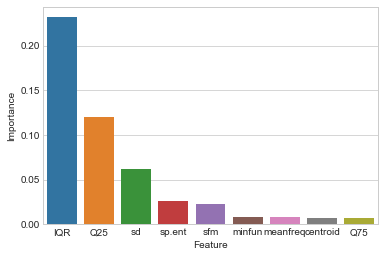

In [189]:
Imp=pd.DataFrame(rf.feature_importances_)
Imp.index=list(voice.columns)
Imp['Feature']=list(voice.columns)
Imp.columns=["Importance","Feature"]
Imp10=Imp.sort_values(by="Importance",ascending=False)[1:10]
sns.barplot(x="Feature", y="Importance", data=Imp10)

In [196]:
list(Imp10.Feature)

['IQR', 'Q25', 'sd', 'sp.ent', 'sfm', 'minfun', 'meanfreq', 'centroid', 'Q75']

#### With PC

In [62]:
param_grid = {'max_depth': [5,10,15],
              'min_samples_split' : [10,30,40],
              'n_estimators':[300],
              'criterion': ['gini', 'entropy']}
rf2 = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=4)
rf2= rf2.fit(voice_pc, y)
rf2.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] criterion=gini, max_depth=5, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_depth=5, min_samples_split=10, n_estimators=300, score=0.8759469696969697, total=   1.0s
[CV] criterion=gini, max_depth=5, min_samples_split=10, n_estimators=300 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, min_samples_split=10, n_estimators=300, score=0.9431818181818182, total=   0.8s
[CV] criterion=gini, max_depth=5, min_samples_split=10, n_estimators=300 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, min_samples_split=10, n_estimators=300, score=0.8816287878787878, total=   0.8s
[CV] criterion=gini, max_depth=5, min_samples_split=10, n_estimators=500 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, min_samples_split=10, n_estimators=500, score=0.8702651515151515, total=   1.4s
[CV] criterion=gini, max_depth=5, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=5, min_samples_split=10, n_estimators=500, score=0.9441287878787878, total=   1.4s
[CV] criterion=gini, max_depth=5, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=5, min_samples_split=10, n_estimators=500, score=0.8693181818181818, total=   1.4s
[CV] criterion=gini, max_depth=5, min_samples_split=30, n_estimators=300 
[CV]  criterion=gini, max_depth=5, min_samples_split=30, n_estimators=300, score=0.8721590909090909, total=   0.9s
[CV] criterion=gini, max_depth=5, min_samples_split=30, n_estimators=300 
[CV]  criterion=gini, max_depth=5, min_samples_split=30, n_estimators=300, score=0.9460227272727273, total=   0.9s
[CV] criterion=gini, max_depth=5, min_samples_split=30, n_estimators=300 
[CV]  criterion=gini, max_depth=5, min_samples_split=30

[CV]  criterion=gini, max_depth=15, min_samples_split=30, n_estimators=500, score=0.8882575757575758, total=   1.7s
[CV] criterion=gini, max_depth=15, min_samples_split=40, n_estimators=300 
[CV]  criterion=gini, max_depth=15, min_samples_split=40, n_estimators=300, score=0.8778409090909091, total=   1.1s
[CV] criterion=gini, max_depth=15, min_samples_split=40, n_estimators=300 
[CV]  criterion=gini, max_depth=15, min_samples_split=40, n_estimators=300, score=0.9479166666666666, total=   1.1s
[CV] criterion=gini, max_depth=15, min_samples_split=40, n_estimators=300 
[CV]  criterion=gini, max_depth=15, min_samples_split=40, n_estimators=300, score=0.8778409090909091, total=   1.1s
[CV] criterion=gini, max_depth=15, min_samples_split=40, n_estimators=500 
[CV]  criterion=gini, max_depth=15, min_samples_split=40, n_estimators=500, score=0.8740530303030303, total=   1.8s
[CV] criterion=gini, max_depth=15, min_samples_split=40, n_estimators=500 
[CV]  criterion=gini, max_depth=15, min_sampl

[CV]  criterion=entropy, max_depth=10, min_samples_split=40, n_estimators=500, score=0.8778409090909091, total=   2.0s
[CV] criterion=entropy, max_depth=15, min_samples_split=10, n_estimators=300 
[CV]  criterion=entropy, max_depth=15, min_samples_split=10, n_estimators=300, score=0.8835227272727273, total=   1.4s
[CV] criterion=entropy, max_depth=15, min_samples_split=10, n_estimators=300 
[CV]  criterion=entropy, max_depth=15, min_samples_split=10, n_estimators=300, score=0.9479166666666666, total=   1.4s
[CV] criterion=entropy, max_depth=15, min_samples_split=10, n_estimators=300 
[CV]  criterion=entropy, max_depth=15, min_samples_split=10, n_estimators=300, score=0.9015151515151515, total=   1.3s
[CV] criterion=entropy, max_depth=15, min_samples_split=10, n_estimators=500 
[CV]  criterion=entropy, max_depth=15, min_samples_split=10, n_estimators=500, score=0.8787878787878788, total=   2.2s
[CV] criterion=entropy, max_depth=15, min_samples_split=10, n_estimators=500 
[CV]  criterion

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.9min finished


{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_split': 10,
 'n_estimators': 300}

Best params: {'criterion': 'gini',
 'max_depth': 10,
 'min_samples_split': 10,
 'n_estimators': 300}

In [229]:
kfold = KFold(n_splits=10,random_state=1)
rf2 = RandomForestClassifier(max_depth = 10,min_samples_split=10, n_estimators = 300, criterion='gini',random_state=0)
rf2.fit(X=voice_pc,y=y)
rf_score_npc=np.mean(cross_val_score(rf2, X=voice, y=y, cv=kfold))

<a name="XGB"></a>
## XGBoost
[Return to Top](#top)

#### Without PC

In [127]:
param_grid = {'max_depth':[2,3,5],
              'min_child_weight':[5],
              'gamma':[0],
              'subsample':[0.8],
              'colsample_bytree':[0.8],
              'learning_rate':[0.1],
              'n_estimators':[100],
              'silent':[1],
              'objective':['binary:logistic']}

xgb = GridSearchCV(XGBClassifier(),param_grid,refit=True,verbose=4)
xgb.fit(voice, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8, score=0.946969696969697, total=   0.2s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s



[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8, score=0.9829545454545454, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8, score=0.9715909090909091, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8, score=0.9535984848484849, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8, score=0.9829545454545454, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8, score=0.9725378787878788, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5,

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 5], 'min_child_weight': [5], 'gamma': [0], 'subsample': [0.8], 'colsample_bytree': [0.8], 'learning_rate': [0.1], 'n_estimators': [100], 'silent': [1], 'objective': ['binary:logistic']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4)

In [128]:
print("Best score: %s" % (xgb.best_score_))
print("Best parameter set: %s" % (xgb.best_params_))

Best score: 0.969696969697
Best parameter set: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8}


Best parameter set: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8}

In [238]:
kfold = KFold(n_splits=10,random_state=1)
xgb = XGBClassifier(colsample_bytree=0.8,
       gamma=0, learning_rate= 0.1,
       max_depth= 3, min_child_weight= 5,
       n_estimators=100,
       objective='binary:logistic',
       silent=1, subsample=0.8)
xgb.fit(X=voice,y=y)
xgb_score_pc=np.mean(cross_val_score(xgb, X=voice, y=y, cv=kfold))
xgb_score_pc

0.96558120033542316

#### With PC

In [232]:
param_grid = {'max_depth':[2,3,5],
              'min_child_weight':[5],
              'gamma':[0],
              'subsample':[0.8],
              'colsample_bytree':[0.8],
              'learning_rate':[0.1],
              'n_estimators':[100],
              'silent':[1],
              'objective':['binary:logistic']}

xgb = GridSearchCV(XGBClassifier(),param_grid,refit=True,verbose=4)
xgb.fit(voice_pc, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8, score=0.8607954545454546, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8, score=0.946969696969697, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8, score=0.8825757575757576, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8, score=0.8607954545454546, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8, score=0.9450757575757576, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, objective=binary:logistic, silent=1, subsample=0.8, score=0.90625, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimato

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 5], 'min_child_weight': [5], 'gamma': [0], 'subsample': [0.8], 'colsample_bytree': [0.8], 'learning_rate': [0.1], 'n_estimators': [100], 'silent': [1], 'objective': ['binary:logistic']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4)

In [233]:
print("Best score: %s" % (xgb.best_score_))
print("Best parameter set: %s" % (xgb.best_params_))

Best score: 0.909090909091
Best parameter set: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8}


In [287]:
kfold = KFold(n_splits=10,random_state=1)
xgb = XGBClassifier(colsample_bytree=0.8,
       gamma=0, learning_rate= 0.1,
       max_depth= 3, min_child_weight= 5,
       n_estimators=100,
       objective='binary:logistic',
       silent=1, subsample=0.8)
xgb.fit(X=voice,y=y)
xgb_score_npc=np.mean(cross_val_score(xgb, X=voice_pc, y=y, cv=kfold))
xgb_score_npc

0.88982150700794627

<a name="GAM"></a>
## GAM
[Return to top](#top)

Note: There's no GAM implementation in sklearn. Pygam is used. Instead of doing 10-folds cv, the accuracy is calculated based on 10 repetitions of train test split.

#### Without PC

In [197]:
ccr = []
for i in range(10):
    voice_train, voice_test, y_train, y_test = train_test_split(voice,y, test_size = 0.1, random_state = i)
    gam = LogisticGAM().fit(X = voice_train,y = (y_train=="female").astype(int))
    predictions = gam.predict(voice_test)
    ccr.append(accuracy_score((y_test=="female").astype(int), predictions))

/Applications/anaconda3/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Applications/anaconda3/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Applications/anaconda3/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
 

In [198]:
np.mean(ccr)

0.97665615141955819

#### With PC

In [ ]:
ccr = []
for i in range(10):
    voice_train, voice_test, y_train, y_test = train_test_split(voice_pc,y, test_size = 0.1, random_state = i)
    gam = LogisticGAM().fit(X = voice_train,y = (y_train=="female").astype(int))
    predictions = gam.predict(voice_test)
    ccr.append(accuracy_score((y_test=="female").astype(int), predictions))

In [92]:
np.mean(ccr)

0.93249211356466888

<a name="NB"></a>
## Naive Bayes

[Return to top](#top)

#### Without PC

In [240]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(voice,y)
nb_score_pc=np.mean(cross_val_score(knn, X=voice, y=y, cv=kfold))

#### With PC

In [241]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(voice_pc,y)
nb_score_npc=np.mean(cross_val_score(knn, X=voice_pc, y=y, cv=kfold))

<a name="RESULTS"></a>
## Final results comparison
[Return to top](#top)

In [298]:
allscores = [{'Method': 'Logistic Regression', 'no PCA': lr_score_pc, 'PCA': lr_score_npc},
         {'Method': 'Neural Network', 'no PCA': nnet_score_pc, 'PCA': nnet_score_npc},
         {'Method': 'CART', 'no PCA': cart_score_pc, 'PCA': cart_score_npc},
         {'Method': 'KNN', 'no PCA': knn_score_pc, 'PCA': knn_score_npc},
         {'Method': 'Boosted Tree', 'no PCA': bt_score_pc, 'PCA': bt_score_npc},
         {'Method': 'Random Forest', 'no PCA': rf_score_pc, 'PCA': rf_score_npc},
         {'Method': 'XGBoost', 'no PCA': xgb_score_pc, 'PCA': xgb_score_npc},
         {'Method': 'SVM', 'no PCA': svm_score_pc, 'PCA': svm_score_npc},
         {'Method': 'Naive Bayes', 'no PCA': nb_score_pc, 'PCA': nb_score_npc}]
df = pd.DataFrame(allscores)
#{'Method': 'GAM', 'PCA': gam_score_pc, 'No PCA': gam_score_npc}

In [303]:
df.index=df['Method']
df[['no PCA','PCA']].sort_values(by="no PCA",ascending=False)

,no PCA,PCA
Method,,
XGBoost,0.965581,0.889822
Boosted Tree,0.962746,0.910967
SVM,0.962436,0.852897
Random Forest,0.962114,0.962429
Neural Network,0.960216,0.931811
Logistic Regression,0.958644,0.844066
CART,0.954844,0.931811
KNN,0.937483,0.902445
Naive Bayes,0.928325,0.902445
